# Sentiment Analysis with Python


## Data Preprocessing


In [2]:
import pandas as pd
df = pd.read_csv(r"C:\Users\HP\Pictures\Github Projects\Tweets.csv")

In [4]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [6]:
review_df = df[['text','airline_sentiment']]

print(review_df.shape)
review_df.head(5)

(14640, 2)


,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


In [10]:
# We don’t really need neutral reviews in our dataset for this binary classification problem. So, we drop those rows from the dataset.
review_df = review_df[review_df['airline_sentiment'] != 'neutral']

print(review_df.shape)
review_df.head(5)


(11541, 2)


,text,airline_sentiment
1,@VirginAmerica plus you've added commercials t...,positive
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative
5,@VirginAmerica seriously would pay $30 a fligh...,negative
6,"@VirginAmerica yes, nearly every time I fly VX...",positive


In [12]:
# Checking the values of the airline_sentiment column.
review_df["airline_sentiment"].value_counts()


airline_sentiment
negative    9178
positive    2363
Name: count, dtype: int64

In [15]:
# converti the categorical values to numeric
sentiment_label = review_df.airline_sentiment.factorize()
sentiment_label

(array([0, 1, 1, ..., 0, 1, 1], dtype=int64),
 Index(['positive', 'negative'], dtype='object'))

The 0 here represents positive sentiment and the 1 represents negative sentiment.

Now we should transform our text data into something that our machine learning model understands. Basically, we need to convert the text into an array of vector embeddings.

In [19]:
# retrieving all the text data from the dataset.

tweet = review_df.text.values

In [21]:
# Now let’s tokenize all the words in the text

from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=5000)

tokenizer.fit_on_texts(tweet)

In [23]:
#replacing the words with their assigned numbers
encoded_docs = tokenizer.texts_to_sequences(tweet)

In [25]:
#pad the sentences to have equal length.

from tensorflow.keras.preprocessing.sequence import pad_sequences

padded_sequence = pad_sequences(encoded_docs, maxlen=200)

## Build the Text Classifier


In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Embedding

# Define constants
vocab_size = 5000  # Replace with your vocabulary size
embedding_vector_length = 32
input_length = 200  # Replace with the actual sequence length of your data

# Build the model
model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_length, input_length=input_length))
model.add(SpatialDropout1D(0.25))
model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
model.build(input_shape=(None, input_length))
print(model.summary())


C:\Users\HP\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 200, 32)        │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_1             │ (None, 200, 32)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        16,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 176,651 (690.04 KB)

 Trainable params: 176,651 (690.04 KB)

 Non-trainable params: 0 (0.00 B)

None


## Training the sentiment analysis model


Training the sentiment analysis model for 5 epochs on the whole dataset with a batch size of 32 and a validation split of 20%.



In [37]:
history = model.fit(padded_sequence,sentiment_label[0],validation_split=0.2, epochs=5, batch_size=32)

Epoch 1/5
289/289 ━━━━━━━━━━━━━━━━━━━━ 32s 84ms/step - accuracy: 0.7789 - loss: 0.5306 - val_accuracy: 0.9013 - val_loss: 0.2390
Epoch 2/5
289/289 ━━━━━━━━━━━━━━━━━━━━ 39s 79ms/step - accuracy: 0.8866 - loss: 0.2919 - val_accuracy: 0.9155 - val_loss: 0.2055
Epoch 3/5
289/289 ━━━━━━━━━━━━━━━━━━━━ 41s 80ms/step - accuracy: 0.9156 - loss: 0.2240 - val_accuracy: 0.9212 - val_loss: 0.1967
Epoch 4/5
289/289 ━━━━━━━━━━━━━━━━━━━━ 23s 80ms/step - accuracy: 0.9318 - loss: 0.1877 - val_accuracy: 0.9285 - val_loss: 0.1824
Epoch 5/5
289/289 ━━━━━━━━━━━━━━━━━━━━ 24s 84ms/step - accuracy: 0.9499 - loss: 0.1409 - val_accuracy: 0.9233 - val_loss: 0.1978


The python sentiment analysis model obtained 94% accuracy on the training set and 92.85% accuracy on the test set.



Plotting the metrics

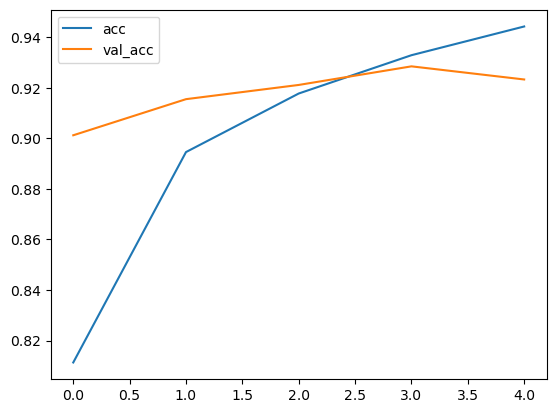

<Figure size 640x480 with 0 Axes>

In [42]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

plt.savefig("Accuracy plot.jpg")

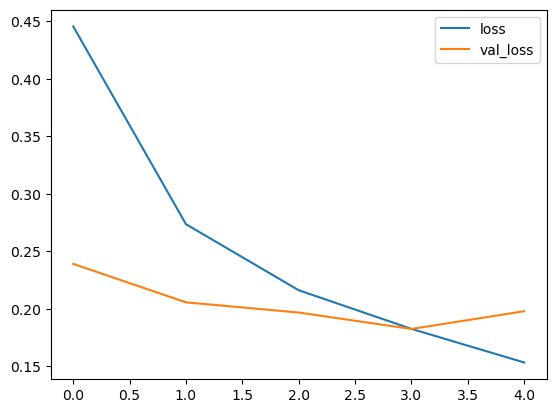

<Figure size 640x480 with 0 Axes>

In [45]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')

plt.legend()
plt.show()

plt.savefig("Loss plt.jpg")

Defining a function that takes a text as input and outputs its prediction label.



In [48]:
def predict_sentiment(text):
    tw = tokenizer.texts_to_sequences([text])
    tw = pad_sequences(tw,maxlen=200)
    prediction = int(model.predict(tw).round().item())
    print("Predicted label: ", sentiment_label[1][prediction])


test_sentence1 = "I enjoyed my journey on this flight."
predict_sentiment(test_sentence1)

test_sentence2 = "This is the worst flight experience of my life!"
predict_sentiment(test_sentence2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step
Predicted label:  positive
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Predicted label:  negative


We have successfully developed python sentiment analysis model. In this machine learning project, we built a binary text classifier that classifies the sentiment of the tweets into positive and negative. We obtained more than 92% accuracy on validation. 
